In [1]:
import datetime
from dateutil.relativedelta import relativedelta
import re

import pandas as pd
import numpy as np
from functools import reduce
from functools import lru_cache

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn import set_config

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline as make_pipeline_with_sampler
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import (
    cross_validate,
    cross_val_predict,
    GridSearchCV,
    learning_curve,
    ShuffleSplit,
)
from sklearn.metrics import recall_score, make_scorer, roc_curve, precision_recall_curve

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier


import warnings

warnings.filterwarnings("ignore")

set_config(display="diagram")

In [2]:
%matplotlib inline

In [3]:
import jupyter_black

jupyter_black.load(lab=False)

<IPython.core.display.Javascript object>

# Task Overview
### Task requirment
This task is to build a churn prediction model in direct debit.

### What has been covered in this notebook?
1. Get the data
2. Explore the data to gain insights:
    * Data quality check
    * Use 6 months rolling window to get the training data and predict churn rate after the period
    * Feature analysis and selection
3. Model Pipeline
4. Models Selection and Evaluation
5. Tuning Model
6. Prediction

# Getting the data

In [4]:
@lru_cache()
def get_data(key: str):
    query = f"""
        SELECT *
        from gc_data_science.{key}
    """
    df = pd.read_gbq(query, project_id="gc-prd-ext-data-test-prod-906c")
    return df

In [5]:
creditors = get_data(key="creditors")
creditors.head()

,id,created_at,has_logo,country_code,merchant_type,refunds_enabled
0,1ede401acc3efb19,2015-11-12 17:25:22.677329+00:00,False,None,None,True
1,9f01178ab94c2877,2016-06-23 14:55:47.322581+00:00,False,None,None,True
2,18f20c90246ab02f,2015-09-30 16:35:20.107268+00:00,False,None,None,True
3,89d2d104c18cb5f8,2016-06-13 14:17:22.728529+00:00,False,None,None,True
4,c75c6bb958723b7e,2015-09-02 11:48:27.204547+00:00,False,None,None,True


In [6]:
mandates = get_data(key="mandates")
mandates.head()

,id,created_at,creditor_id,scheme,payments_require_approval,is_business_customer_type
0,48bd8ece0e8b3cce,2016-08-04 10:02:33.753039+00:00,000272d8d04f3ed2,bacs,True,False
1,82464146cf7fb83a,2016-07-26 06:18:06.422498+00:00,000c22bf511987ff,bacs,False,False
2,0ea8942e42390cac,2016-09-12 11:21:53.023428+00:00,000c22bf511987ff,bacs,False,False
3,859c70bb8de7f063,2016-07-25 17:07:19.626298+00:00,000c22bf511987ff,bacs,False,False
4,bc678786559c8f04,2016-07-07 16:19:01.310005+00:00,000c22bf511987ff,bacs,False,False


In [7]:
payments = get_data(key="payments")
payments.head()

,id,created_at,mandate_id,creditor_id,amount_gbp,source,has_description,has_reference
0,976c5e2656e7f235,2016-01-25 11:34:07.130402+00:00,0cdd448547d27439,0093c87314409557,796.96,api,True,False
1,4ecb4a344587c054,2016-01-25 11:36:20.031702+00:00,f1c81524badbd399,0093c87314409557,59.08,api,True,False
2,cb6235b5ea8270af,2016-01-25 11:36:34.545871+00:00,466e9e479bd3b5c5,0093c87314409557,1328.84,api,True,False
3,00903726a58af2c2,2016-01-25 11:34:57.142141+00:00,5319d1cdd0836cd5,0093c87314409557,1450.90,api,True,False
4,0d74bf0ad2f9557c,2016-01-25 11:36:11.721374+00:00,0c813e32149567ac,0093c87314409557,3814.84,api,True,False


In [8]:
print("creditor columns")
print(creditors.columns.tolist())

print("mandate columns")
print(mandates.columns.tolist())

print("payments columns")
print(payments.columns.tolist())

creditor columns
['id', 'created_at', 'has_logo', 'country_code', 'merchant_type', 'refunds_enabled']
mandate columns
['id', 'created_at', 'creditor_id', 'scheme', 'payments_require_approval', 'is_business_customer_type']
payments columns
['id', 'created_at', 'mandate_id', 'creditor_id', 'amount_gbp', 'source', 'has_description', 'has_reference']


In [9]:
# join three tables
merged = (
    creditors.rename(columns={"id": "creditor_id", "created_at": "creditor_created_at"})
    .merge(
        mandates.rename(
            columns={"id": "mandate_id", "created_at": "mandate_created_at"}
        ),
        on="creditor_id",
    )
    .merge(
        payments.rename(
            columns={"id": "payment_id", "created_at": "payment_created_at"}
        ),
        on=("creditor_id", "mandate_id"),
    )
)

In [10]:
merged.head()

,creditor_id,creditor_created_at,has_logo,country_code,merchant_type,refunds_enabled,mandate_id,mandate_created_at,scheme,payments_require_approval,is_business_customer_type,payment_id,payment_created_at,amount_gbp,source,has_description,has_reference
0,1ede401acc3efb19,2015-11-12 17:25:22.677329+00:00,False,None,None,True,505e6f42fb9d2a6b,2016-01-19 12:14:08.429078+00:00,sepa_core,False,False,939507a36fd415e1,2016-01-28 01:25:05.397819+00:00,23.91,api,True,False
1,1ede401acc3efb19,2015-11-12 17:25:22.677329+00:00,False,None,None,True,505e6f42fb9d2a6b,2016-01-19 12:14:08.429078+00:00,sepa_core,False,False,67f53e5fc4c6e919,2016-02-25 01:25:04.541365+00:00,20.30,api,True,True
2,1ede401acc3efb19,2015-11-12 17:25:22.677329+00:00,False,None,None,True,505e6f42fb9d2a6b,2016-01-19 12:14:08.429078+00:00,sepa_core,False,False,8050b1864f6e97c8,2016-03-29 00:00:03.523634+00:00,21.72,api,True,True
3,1ede401acc3efb19,2015-11-12 17:25:22.677329+00:00,False,None,None,True,505e6f42fb9d2a6b,2016-01-19 12:14:08.429078+00:00,sepa_core,False,False,e0dd84fc204cd6df,2016-05-27 00:00:03.672784+00:00,26.84,api,True,True
4,1ede401acc3efb19,2015-11-12 17:25:22.677329+00:00,False,None,None,True,505e6f42fb9d2a6b,2016-01-19 12:14:08.429078+00:00,sepa_core,False,False,7301f640fff32f0f,2016-11-28 01:00:02.499173+00:00,24.16,api,True,True


In [11]:
cond = merged["payment_created_at"] >= datetime.datetime(
    2016, 10, 1, tzinfo=datetime.timezone.utc
)
churned_creditor_ids_preQ4 = set(merged["creditor_id"]) - set(
    merged[cond]["creditor_id"]
)

In [12]:
temp = merged[merged["creditor_id"].isin(churned_creditor_ids_preQ4)]

In [13]:
new = (
    temp.groupby(["creditor_id"])
    .agg(active_payment_aging=("payment_created_at", lambda x: np.ptp(x).days + 1))
    .reset_index()
)

In [14]:
new

,creditor_id,active_payment_aging
0,000272d8d04f3ed2,1
1,004530bd843ec307,1
2,0093c87314409557,1
3,00b539bdf2a1adf3,1
4,00bfd92417d0c5ba,44
...,...,...
2080,ff089a3b25d67755,1
2081,ff529a7afc94e3fa,43
2082,ff89eb9c6d63b6b8,1
2083,ff9b2d94e999a701,45


<AxesSubplot:xlabel='active_payment_aging', ylabel='Count'>

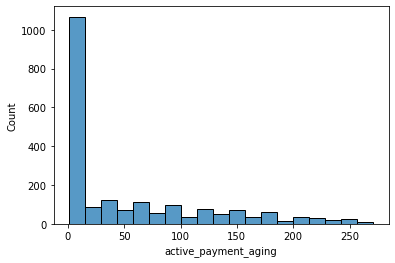

In [15]:
sns.histplot(data=new, x="active_payment_aging")

# Data Quality Check

The following section focus on the data quality for each tables. I mainly focus on

**Data Type**:
`object`, `datetime`, `boolean`, `float`

**Missing Data Type**:

Two columns have missing values: `country_code` and `merchant_type`

**Data Outlier**:

Inlogic Data Record: I have checked payment amounts consistency and time consistency. 

The logical data consistency is: `creditor_created_at < mandate_created_at < payment_created_at`. But there are 170 records didn't match this logic. 

In [16]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 237660 entries, 0 to 237659
Data columns (total 17 columns):
 #   Column                     Non-Null Count   Dtype              
---  ------                     --------------   -----              
 0   creditor_id                237660 non-null  object             
 1   creditor_created_at        237660 non-null  datetime64[ns, UTC]
 2   has_logo                   237660 non-null  boolean            
 3   country_code               208402 non-null  object             
 4   merchant_type              235760 non-null  object             
 5   refunds_enabled            237660 non-null  boolean            
 6   mandate_id                 237660 non-null  object             
 7   mandate_created_at         237660 non-null  datetime64[ns, UTC]
 8   scheme                     237660 non-null  object             
 9   payments_require_approval  237660 non-null  boolean            
 10  is_business_customer_type  237660 non-null  boolean     

Country Code
Total % of Missing Value: 12.310864259867037


<AxesSubplot:xlabel='country_code', ylabel='count'>

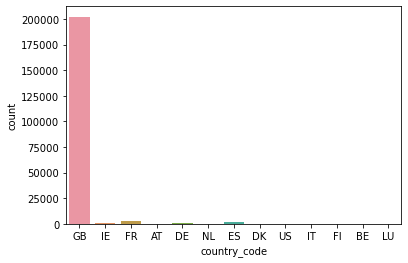

In [17]:
print("Country Code")
print(
    "Total % of Missing Value:",
    merged["country_code"].isnull().sum() / len(merged) * 100,
)
sns.countplot(x="country_code", data=merged)

merchant type
Total % of Missing Value: 0.7994614154674746


<AxesSubplot:xlabel='merchant_type', ylabel='count'>

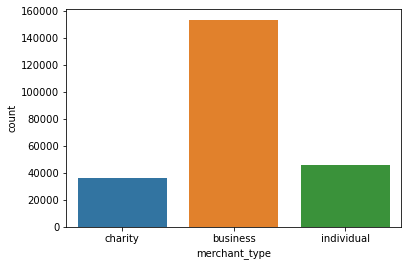

In [18]:
# merged.loc[merged["country_code"].isnull(), "country_code"]="N/A"
print("merchant type")
print(
    "Total % of Missing Value:",
    merged["merchant_type"].isnull().sum() / len(merged) * 100,
)
sns.countplot(x="merchant_type", data=merged)

In [19]:
print(merged.dtypes.value_counts())

object                 7
boolean                6
datetime64[ns, UTC]    3
float64                1
dtype: int64


In [20]:
# Data Outlier: The logical data consistency is: `creditor_created_at < mandate_created_at < payment_created_at`
cond = merged["creditor_created_at"] >= merged["mandate_created_at"]
cond |= merged["mandate_created_at"] >= merged["payment_created_at"]
display(merged[cond])

,creditor_id,creditor_created_at,has_logo,country_code,merchant_type,refunds_enabled,mandate_id,mandate_created_at,scheme,payments_require_approval,is_business_customer_type,payment_id,payment_created_at,amount_gbp,source,has_description,has_reference
122,9f01178ab94c2877,2016-06-23 14:55:47.322581+00:00,False,None,None,True,ea5635649a73248b,2016-04-20 00:04:40.284013+00:00,bacs,False,False,dfc95825dfe566e2,2016-10-14 14:02:21.496290+00:00,30.58,api,True,False
123,9f01178ab94c2877,2016-06-23 14:55:47.322581+00:00,False,None,None,True,ea5635649a73248b,2016-04-20 00:04:40.284013+00:00,bacs,False,False,bb92d1088b9c1b7e,2016-11-14 14:02:36.648466+00:00,29.72,api,True,False
124,9f01178ab94c2877,2016-06-23 14:55:47.322581+00:00,False,None,None,True,b0f86a46c889da77,2016-01-20 18:39:17.339822+00:00,bacs,False,False,0340f7dfaa532b25,2016-09-14 14:01:33.585694+00:00,15.13,api,True,False
125,9f01178ab94c2877,2016-06-23 14:55:47.322581+00:00,False,None,None,True,b0f86a46c889da77,2016-01-20 18:39:17.339822+00:00,bacs,False,False,7fd042052cde79a2,2016-11-14 14:01:52.712281+00:00,20.89,api,True,False
126,9f01178ab94c2877,2016-06-23 14:55:47.322581+00:00,False,None,None,True,b0f86a46c889da77,2016-01-20 18:39:17.339822+00:00,bacs,False,False,63848bb9d0412052,2016-12-14 14:02:39.299488+00:00,19.23,api,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353,9f01178ab94c2877,2016-06-23 14:55:47.322581+00:00,False,None,None,True,f668feccad105c8a,2016-01-26 12:57:29.004755+00:00,bacs,False,True,a4857d7d1a7fed82,2016-09-14 14:00:40.399985+00:00,9.62,api,True,False
354,9f01178ab94c2877,2016-06-23 14:55:47.322581+00:00,False,None,None,True,f668feccad105c8a,2016-01-26 12:57:29.004755+00:00,bacs,False,True,08ef9e68d8d28ef3,2016-10-14 14:00:36.544529+00:00,8.83,api,True,False
355,9f01178ab94c2877,2016-06-23 14:55:47.322581+00:00,False,None,None,True,6a600f0d39f2fd24,2015-12-20 13:19:27.060944+00:00,bacs,False,True,7933a76dc414c759,2016-12-14 14:02:28.482105+00:00,10.23,api,True,False
356,9f01178ab94c2877,2016-06-23 14:55:47.322581+00:00,False,None,None,True,6a600f0d39f2fd24,2015-12-20 13:19:27.060944+00:00,bacs,False,True,749c77c20a3f01ec,2016-09-14 14:01:23.019777+00:00,23.12,api,True,False


# Data Analysis

After joining `creditors`, `mandates` and `payments` tables together, I apply a rolling window on payments' `created_at` column and then tranform to get training data (see `rolling_tranform` function in jupyter notebook). 

As I think quarterly data would bear more information of business activity patterns, I compared 3, 6, 9 months for the rolling window size.

I select 6-month windows as ML models generally perform better on the 6-month data.

I use function `process_creditor_data_initial` to create as many as features (payment statistics and mandate statistics) based on creditor level. Then I focus on feature analysis on dataset from three areas:

**1. creditor level information** 

`has_logo`,`country_code`, `merchant_type`,`refunds_enabled`

**2. mandates statistics information based on creditor level**
* `pct_payments_require_approval`: the percentage of mandates that its `payments_require_approval`
* `pct_is_business_customer_type`: the percentage of mandates which `is_business_customer_type`
* `num_mandates`: number of mandates 
* `pct_scheme_bacs`: the percentage of bacs scheme which is `scheme == "basc"`

**3. payment statistics information based on creditor level**
* `amount_mean`: average amount
* `amount_median`: median amount
* `amount_sum:`: total amount
* `num_payments`: number of payments
* `active_aging`:  the difference (in days) between the last `payment_created_at` and the first `payment_created_at` 
* `avg_payment_interval`: avgerage payment interval (`active_aging/num_payments`)
* `pct_has_ref`: the percentage of payments which `has_reference`
* `pct_has_description`: the percentage of payments with description `has_description`
* `pct_source_api`: the percentage of payments via api 
* `pct_source_app`: the percentage of payments via app 


In [21]:
def process_creditor_data_initial(all_data):
    # payment stats
    payments_stats = (
        all_data[
            [
                "creditor_id",
                "amount_gbp",
                "payment_created_at",
                "has_reference",
                "has_description",
                "source",
            ]
        ]
        .groupby("creditor_id")
        .agg(
            amount_mean=("amount_gbp", np.mean),
            amount_median=("amount_gbp", np.median),
            amount_sum=("amount_gbp", np.sum),
            num_payments=("amount_gbp", len),
            active_aging=("payment_created_at", lambda x: np.ptp(x).days + 1),
            avg_payment_interval=(
                "payment_created_at",
                lambda x: (np.ptp(x).days + 1) / len(x),
            ),
            pct_has_ref=("has_reference", np.mean),
            pct_has_description=("has_description", np.mean),
            pct_source_api=(
                "source",
                lambda x: sum(1 for s in x if s == "api") / len(x),
            ),
            pct_source_app=(
                "source",
                lambda x: sum(1 for s in x if s == "app") / len(x),
            ),
        )
        .reset_index()
    )

    # mandate stats
    creditors_mandates = all_data[
        [
            "creditor_id",
            "mandate_id",
            "payments_require_approval",
            "is_business_customer_type",
            "mandate_created_at",
            "scheme",
        ]
    ].drop_duplicates()
    mandates_stats = (
        creditors_mandates[
            [
                "creditor_id",
                "mandate_id",
                "payments_require_approval",
                "is_business_customer_type",
                "mandate_created_at",
                "scheme",
            ]
        ]
        .groupby("creditor_id")
        .agg(
            pct_payments_require_approval=("payments_require_approval", np.mean),
            pct_is_business_customer_type=("is_business_customer_type", np.mean),
            num_mandates=("mandate_id", len),
            pct_scheme_bacs=(
                "scheme",
                lambda x: sum(1 for s in x if s == "bacs") / len(x),
            ),
        )
        .reset_index()
    )

    dfs = [
        payments_stats,
        mandates_stats,
        all_data[
            [
                "creditor_id",
                "has_logo",
                "country_code",
                "merchant_type",
                "refunds_enabled",
                "creditor_created_at",
            ]
        ].drop_duplicates(),
    ]
    data = reduce(lambda left, right: left.merge(right, how="left"), dfs)

    return data

In [22]:
def rolling_tranform(
    df,
    *,
    periods=6,
    unit="months",
    stride="14D",
    agg_func=process_creditor_data_initial
):
    # By default, 6-month time-period rolling with 2-week stride.
    # The last period ends on or before 2016-10-01 as we need at least three month time to tell if churned or not

    creditor_ids = set(df["creditor_id"])
    dfs = []

    d0 = df["payment_created_at"].min().date()
    d1 = (
        df["payment_created_at"].max()
        - relativedelta(**{unit: periods})
        - relativedelta(months=3)
    ).date() + datetime.timedelta(days=1)

    for start in pd.date_range(d0, d1, freq=stride, tz="utc"):
        end = pd.to_datetime(start + relativedelta(**{unit: periods}))

        sub_df = df[
            (start <= df["payment_created_at"]) & (df["payment_created_at"] < end)
        ]
        agg = process_creditor_data_initial(sub_df)

        churned_ids = creditor_ids - set(
            df[df["payment_created_at"] >= end]["creditor_id"]
        )

        agg["churned_creditor"] = agg["creditor_id"].isin(churned_ids).astype(int)
        agg["period_start"] = start
        agg["period_end"] = end

        dfs.append(agg)

    return pd.concat(dfs).reset_index(drop=True)

# Use 6 months for rolling window to predict churn rate after the period

In [23]:
df = rolling_tranform(merged, periods=6, stride="30D")
print(df.groupby(["period_start", "period_end"]).size())
print("*" * 40)
print("The number of training data:", len(df))
display(df.tail())

period_start               period_end               
2016-01-01 00:00:00+00:00  2016-07-01 00:00:00+00:00    4635
2016-01-31 00:00:00+00:00  2016-07-31 00:00:00+00:00    4723
2016-03-01 00:00:00+00:00  2016-09-01 00:00:00+00:00    4775
2016-03-31 00:00:00+00:00  2016-09-30 00:00:00+00:00    4854
dtype: int64
****************************************
The number of training data: 18987


,creditor_id,amount_mean,amount_median,amount_sum,num_payments,active_aging,avg_payment_interval,pct_has_ref,pct_has_description,pct_source_api,...,num_mandates,pct_scheme_bacs,has_logo,country_code,merchant_type,refunds_enabled,creditor_created_at,churned_creditor,period_start,period_end
18982,ffcaac16ad7f1201,26.294696,24.020,18590.35,707,182,0.257426,0.0,0.998586,0.0,...,186,1.0,True,GB,business,False,2014-07-21 12:15:21.049171+00:00,0,2016-03-31 00:00:00+00:00,2016-09-30 00:00:00+00:00
18983,ffcb16abe66eabd6,9.765455,9.830,107.42,11,126,11.454545,0.0,1.0,0.0,...,5,1.0,True,GB,individual,False,2015-04-21 11:47:16.223130+00:00,0,2016-03-31 00:00:00+00:00,2016-09-30 00:00:00+00:00
18984,ffcbd2e29846feb6,49.392132,32.745,13434.66,272,167,0.613971,0.0,1.0,0.0,...,94,1.0,True,GB,individual,False,2015-11-25 10:38:42.330655+00:00,0,2016-03-31 00:00:00+00:00,2016-09-30 00:00:00+00:00
18985,ffdb6e5fd5cb6dd1,45.960083,43.650,5561.17,121,155,1.280992,0.0,1.0,0.0,...,40,1.0,True,GB,individual,False,2015-02-05 15:57:08.918500+00:00,0,2016-03-31 00:00:00+00:00,2016-09-30 00:00:00+00:00
18986,ffdd0f33d33cbb8a,135.730000,135.730,135.73,1,1,1.000000,0.0,0.0,1.0,...,1,1.0,True,GB,business,False,2016-06-05 22:42:01.175846+00:00,1,2016-03-31 00:00:00+00:00,2016-09-30 00:00:00+00:00


0    13164
1     5823
Name: churned_creditor, dtype: int64


<AxesSubplot:xlabel='churned_creditor', ylabel='count'>

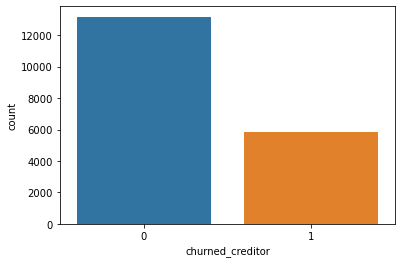

In [24]:
# class distribution
print(df["churned_creditor"].value_counts())
sns.countplot(data=df, x=df["churned_creditor"])

In [25]:
print("Missing Value statistics")
df.isnull().sum() / len(df) * 100

Missing Value statistics


creditor_id                       0.000000
amount_mean                       0.000000
amount_median                     0.000000
amount_sum                        0.000000
num_payments                      0.000000
active_aging                      0.000000
avg_payment_interval              0.000000
pct_has_ref                       0.000000
pct_has_description               0.000000
pct_source_api                    0.000000
pct_source_app                    0.000000
pct_payments_require_approval     0.000000
pct_is_business_customer_type     0.000000
num_mandates                      0.000000
pct_scheme_bacs                   0.000000
has_logo                          0.000000
country_code                     14.209722
merchant_type                     0.832148
refunds_enabled                   0.000000
creditor_created_at               0.000000
churned_creditor                  0.000000
period_start                      0.000000
period_end                        0.000000
dtype: floa

## Feature Analysis

### 1. Creditor Level

`merchant_type`:
* 0.83% null values. For those null value, I will replace them with the most frequent value, which is `business`.
* Frequency: business > individual > charity
* Churn rate is individual > charity > bussiness

`refunds_enabled`: lower churn rate when `False`. By significance `merchant_type`: charity >  individual > business

`has_logo`: lower churn rate when the creditor has a logo

`country_code`:
* 14.2% null values
* not strongly correlated with churn rate. Excluded. 

In summary, `merchant_type`, `refunds_enabled` and `has_logo` are selected as model features.

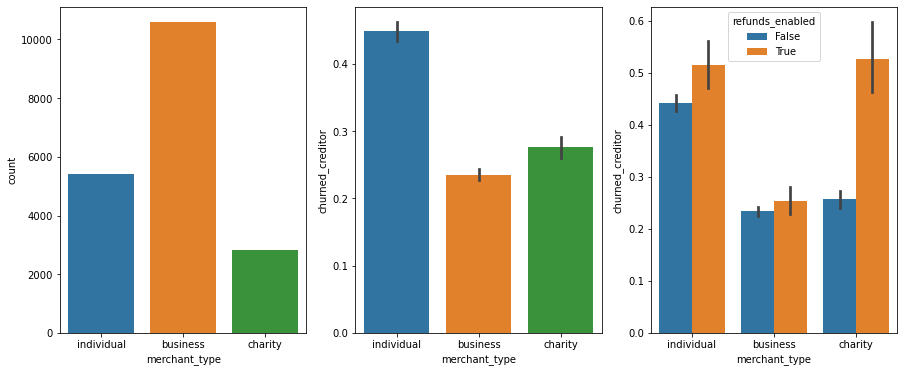

In [26]:
# creditor level for merchant_type and refunds_enabled
fig, axes = plt.subplots(ncols=3, figsize=(15, 6))
params = dict(
    y="churned_creditor",
    x="merchant_type",
)

sns.countplot(data=df, x="merchant_type", ax=axes[0])

sns.barplot(
    data=df,
    **params,
    ax=axes[1],
)

sns.barplot(
    data=df, y="churned_creditor", x="merchant_type", hue="refunds_enabled", ax=axes[2]
)

df["merchant_type"].fillna("business", inplace=True)

<AxesSubplot:xlabel='has_logo', ylabel='churned_creditor'>

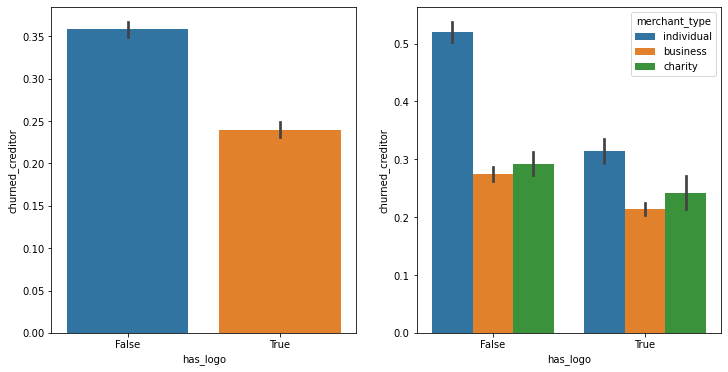

In [27]:
# creditor level for has logo
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))

params = dict(x="has_logo", y="churned_creditor")

sns.barplot(
    data=df,
    **params,
    ax=axes[0],
)

sns.barplot(data=df, **params, hue="merchant_type", ax=axes[1])

<AxesSubplot:xlabel='country_code', ylabel='churned_creditor'>

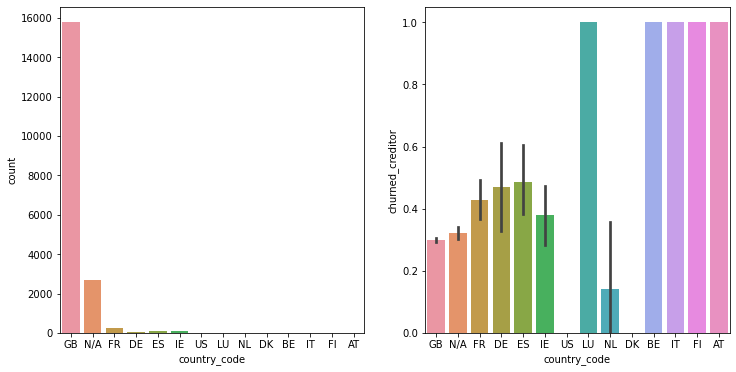

In [28]:
# creditor level for country_code:
# Replace null value to 'N/A'
df.loc[df["country_code"].isnull(), "country_code"] = "N/A"

fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
params = dict(
    y="churned_creditor",
    x="country_code",
)

sns.countplot(data=df, x="country_code", ax=axes[0])

sns.barplot(
    data=df,
    **params,
    ax=axes[1],
)

### 2. Mandates statistics information based on creditor level

`pct_payments_require_approval`: the percentage of mandates requiring an approval per creditor
* Positive correlated with churn rate when requiring a payment approval. 
* It might happen that people may regret setting up the mandate when they review the payment, so it is more likely for them to cease the mandate.

`pct_is_business_customer_type`: the percentage of mandates with business customer type per creditor
* Negative correlated with churn rate when a mandate request is a business customer type
* Business customers have more stable expenditure plan and less likely to cancel mandate randomly

`num_mandates`: the number of mandates per creditor
* the more number of mandates made, the lower churn rate

`pct_scheme_bacs`: percentage of bacs scheme per creditor
* No significantly correlated on churn rate. Excluded.

In summary, `pct_payments_require_approval`, `pct_is_business_customer_type` and `num_mandates` are selected as model features.

In [29]:
cols = [
    "creditor_id",
    "merchant_type",
    "pct_payments_require_approval",
    "pct_is_business_customer_type",
    "num_mandates",
    "pct_scheme_bacs",
    "churned_creditor",
]
mandates_stats = df[cols]

In [30]:
mandates_stats.head()

,creditor_id,merchant_type,pct_payments_require_approval,pct_is_business_customer_type,num_mandates,pct_scheme_bacs,churned_creditor
0,000dcdef6d4373fd,individual,0.0,0.0,5,1.0,0
1,00337e15ad545f99,business,0.0,1.0,2,1.0,0
2,0035ef68cf8c1a7e,business,1.0,0.0,1,1.0,0
3,008d459d197d14bc,individual,0.0,0.0,2,1.0,0
4,0090bfc8c4232ca1,charity,0.3,0.0,30,1.0,0


In [31]:
def plot_multi_features(df):
    columns = [
        col
        for col in df.select_dtypes(include=[np.float, np.int]).columns.tolist()
        if col != "churned_creditor"
    ]

    nrows, ncols = len(columns), 2
    fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 4 * nrows))

    for i, col in enumerate(columns):
        i = i * 2
        sns.barplot(
            data=df,
            y=col,
            x="churned_creditor",
            ax=axes[i // ncols][i % ncols],
        )

        i = i + 1
        sns.barplot(
            data=df,
            y=col,
            x="churned_creditor",
            hue="merchant_type",
            ax=axes[i // ncols][i % ncols],
        )

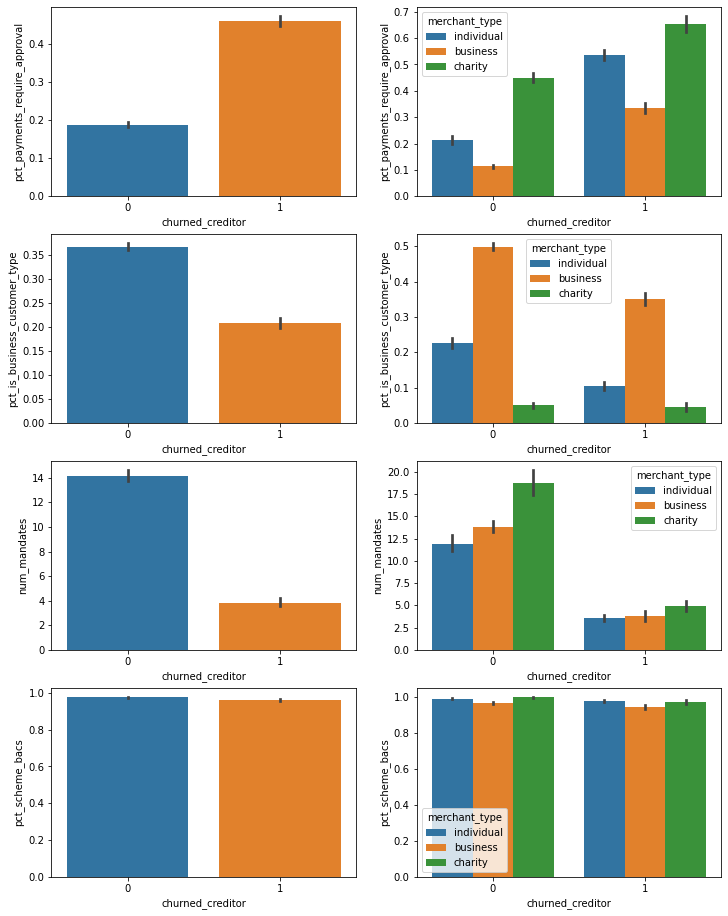

In [32]:
plot_multi_features(mandates_stats)

In [33]:
cols = [
    "creditor_id",
    "merchant_type",
    "pct_payments_require_approval",
    "pct_is_business_customer_type",
    "num_mandates",
    "churned_creditor",
]
mandates_stats_new = df[cols]

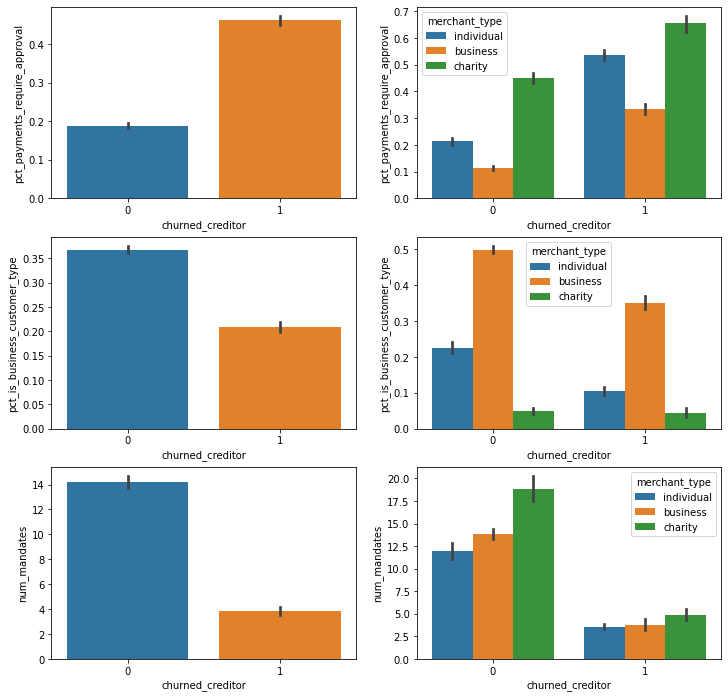

In [34]:
plot_multi_features(mandates_stats_new)

### payment statistics information based on creditor level

Analyse statistics of payments for each creditor:
* `amount_mean`: average amount
* `amount_median`: median amount 
* `amount_sum:`: total amount
* `num_payments`: total number of payments 
* `active_aging`:  the difference (in days) between the last `payment_created_at` and the first `payment_created_at` 
* `avg_payment_interval`: the avgerage payment interval (`active_aging/num_payments`)
* `pct_has_ref`: the percentage of payments with reference 
* `pcr_has_description`: the percentage of payments with description
* `pct_source_api`: the percentage of payments via api
* `pct_source_app`: the percentage of payments via app

In summary, the following features have strong impact on creditor churn rate:
* `amount_sum`: the lower the total amount, the higher creditor churn rate
* `num_payments`: the less number of payments, the higher creditor churn rate
* `active_aging`: the shorter active payment time span, the higher creditor churn rate
* `pct_has_ref`: the higher percentage of payments having a reference, the higher creditor churn rate 
* `pct_source_api`: the higher percentage of payments via api, the lower creditor churn rate
* `pct_source_app`: the higher percentage of payments via app, the higher creditor churn rate

In [35]:
cols = [
    "creditor_id",
    "merchant_type",
    "amount_mean",
    "amount_median",
    "amount_sum",
    "num_payments",
    "active_aging",
    "avg_payment_interval",
    "pct_has_ref",
    "pct_has_description",
    "pct_source_api",
    "pct_source_app",
    "churned_creditor",
]
payments_stats = df[cols]
payments_stats.head()

,creditor_id,merchant_type,amount_mean,amount_median,amount_sum,num_payments,active_aging,avg_payment_interval,pct_has_ref,pct_has_description,pct_source_api,pct_source_app,churned_creditor
0,000dcdef6d4373fd,individual,62.566154,68.470,813.36,13,151,11.615385,0.0,1.0,0.0,1.0,0
1,00337e15ad545f99,business,100.783750,56.325,806.27,8,152,19.000000,0.0,1.0,0.0,0.0,0
2,0035ef68cf8c1a7e,business,215.450000,215.450,215.45,1,1,1.000000,0.0,1.0,0.0,1.0,0
3,008d459d197d14bc,individual,40.250000,41.000,120.75,3,60,20.000000,0.0,0.333333,0.0,1.0,0
4,0090bfc8c4232ca1,charity,6.989623,6.370,370.45,53,180,3.396226,0.0,1.0,0.0,1.0,0


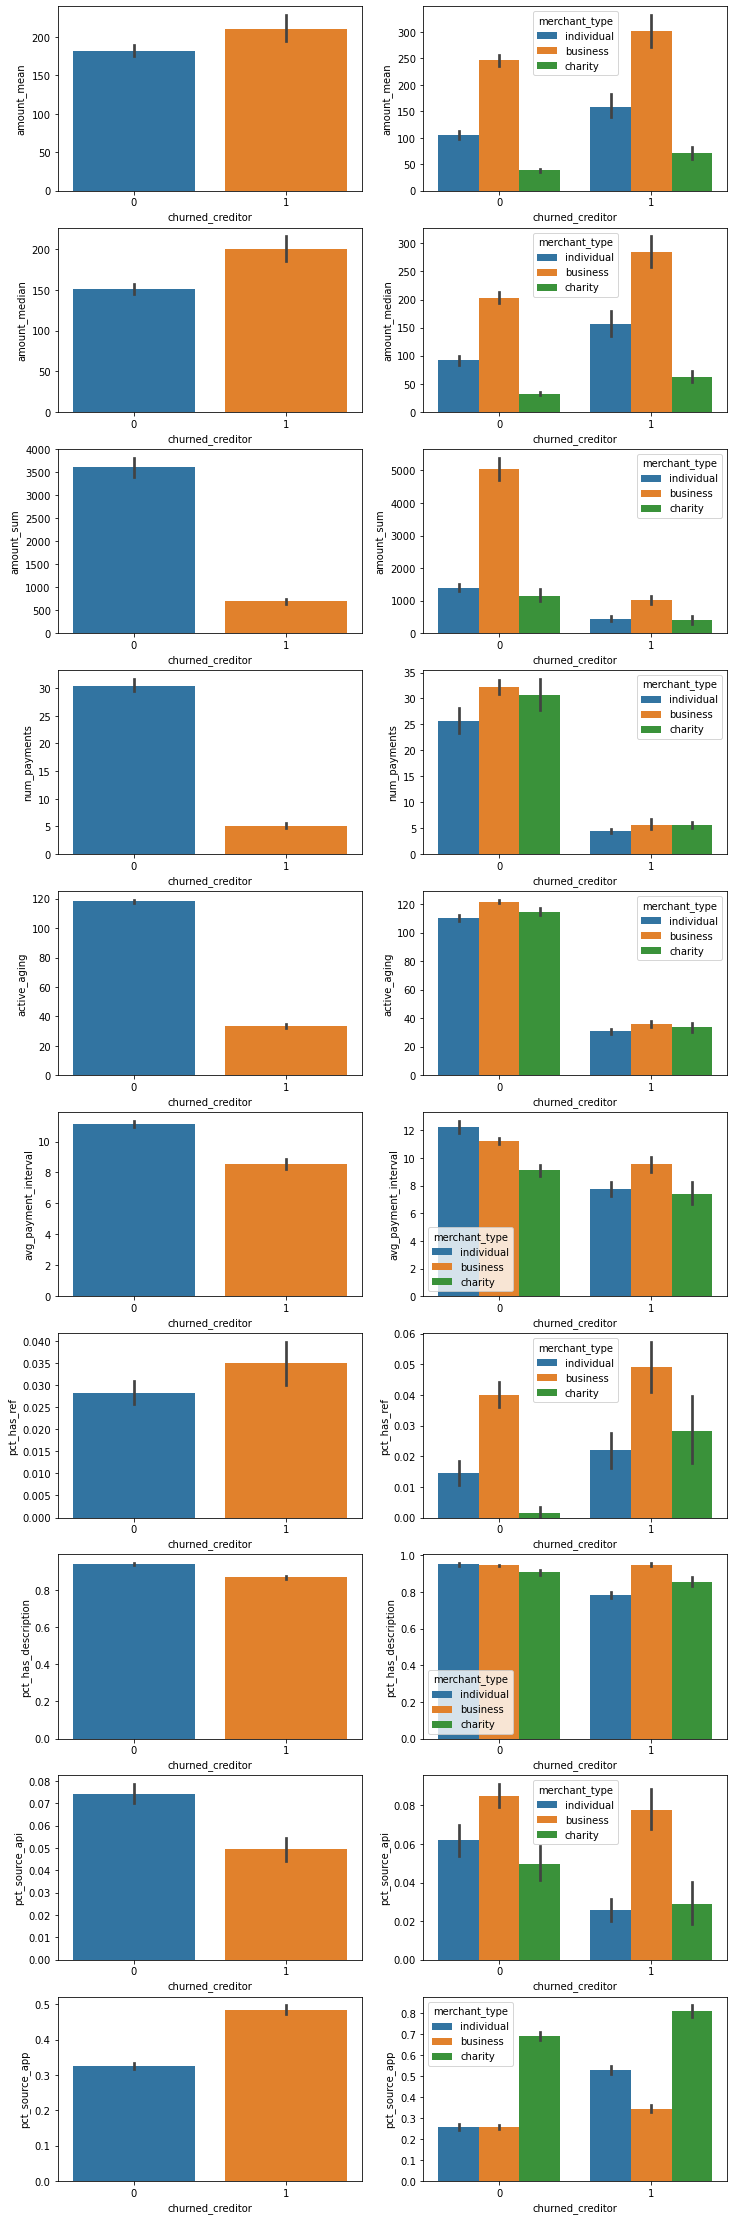

In [36]:
plot_multi_features(payments_stats)

In [37]:
cols = [
    "creditor_id",
    "merchant_type",
    #     "amount_sum",
    #     "num_payments",
    #     "active_aging",
    "pct_has_ref",
    "pct_source_api",
    "pct_source_app",
    "churned_creditor",
]
payments_stats_new = df[cols]
payments_stats_new.head()

,creditor_id,merchant_type,pct_has_ref,pct_source_api,pct_source_app,churned_creditor
0,000dcdef6d4373fd,individual,0.0,0.0,1.0,0
1,00337e15ad545f99,business,0.0,0.0,0.0,0
2,0035ef68cf8c1a7e,business,0.0,0.0,1.0,0
3,008d459d197d14bc,individual,0.0,0.0,1.0,0
4,0090bfc8c4232ca1,charity,0.0,0.0,1.0,0


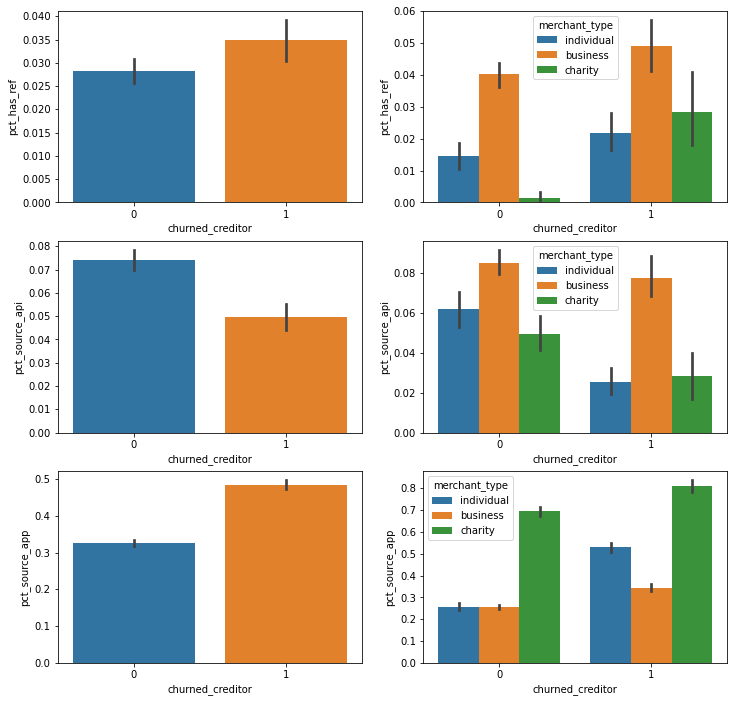

In [38]:
plot_multi_features(payments_stats_new)

# Feature Selection

According to the above feature anlaysis, I will consider the following features:
1. `has_logo`
1. `merchant_type`
1. `refunds_enabled`
1. `pct_payments_require_approval`
1. `pct_is_business_customer_type`
1. `num_mandates`
1. `amount_sum`
1. `num_payments`
1. `active_aging`
1. `pct_has_ref`
1. `pct_source_api`
1. `pct_source_app`

Function `process_creditor_data` is used to generate these features and add to the data

In [39]:
def process_creditor_data(creditor_payments):
    # payment stats
    payments_stats = (
        creditor_payments[
            [
                "creditor_id",
                "amount_gbp",
                "payment_created_at",
                "has_reference",
                "has_description",
                "source",
            ]
        ]
        .groupby("creditor_id")
        .agg(
            amount_sum=("amount_gbp", np.sum),
            num_payments=("amount_gbp", len),
            active_aging=("payment_created_at", lambda x: np.ptp(x).days + 1),
            pct_has_ref=("has_reference", np.mean),
            pct_source_api=(
                "source",
                lambda x: sum(1 for s in x if s == "api") / len(x),
            ),
            pct_source_app=(
                "source",
                lambda x: sum(1 for s in x if s == "app") / len(x),
            ),
        )
        .reset_index()
    )

    # mandate stats
    creditors_mandates = creditor_payments[
        [
            "creditor_id",
            "mandate_id",
            "payments_require_approval",
            "is_business_customer_type",
            "scheme",
        ]
    ].drop_duplicates()
    mandates_stats = (
        creditors_mandates[
            [
                "creditor_id",
                "mandate_id",
                "payments_require_approval",
                "is_business_customer_type",
                "scheme",
            ]
        ]
        .groupby("creditor_id")
        .agg(
            pct_payments_require_approval=("payments_require_approval", np.mean),
            pct_is_business_customer_type=("is_business_customer_type", np.mean),
            num_mandates=("mandate_id", len),
            pct_scheme_bacs=(
                "scheme",
                lambda x: sum(1 for s in x if s == "bacs") / len(x),
            ),
        )
        .reset_index()
    )

    dfs = [
        payments_stats,
        mandates_stats,
        creditor_payments[
            [
                "creditor_id",
                "has_logo",
                "merchant_type",
                "refunds_enabled",
            ]
        ].drop_duplicates(),
    ]
    data = reduce(lambda left, right: left.merge(right, how="left"), dfs)

    return data

<AxesSubplot:>

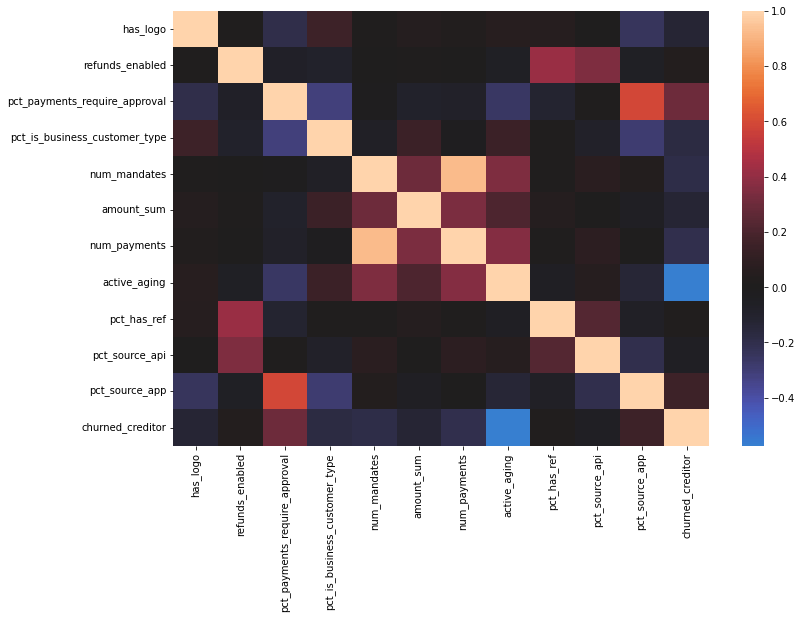

In [83]:
cols = [
    "has_logo",
    "merchant_type",
    "refunds_enabled",
    "pct_payments_require_approval",
    "pct_is_business_customer_type",
    "num_mandates",
    "amount_sum",
    "num_payments",
    "active_aging",
    "pct_has_ref",
    "pct_source_api",
    "pct_source_app",
    "churned_creditor",
]
plt.figure(figsize=(12, 8))
corr = df[cols].select_dtypes("number").corr()
sns.heatmap(corr, center=0)

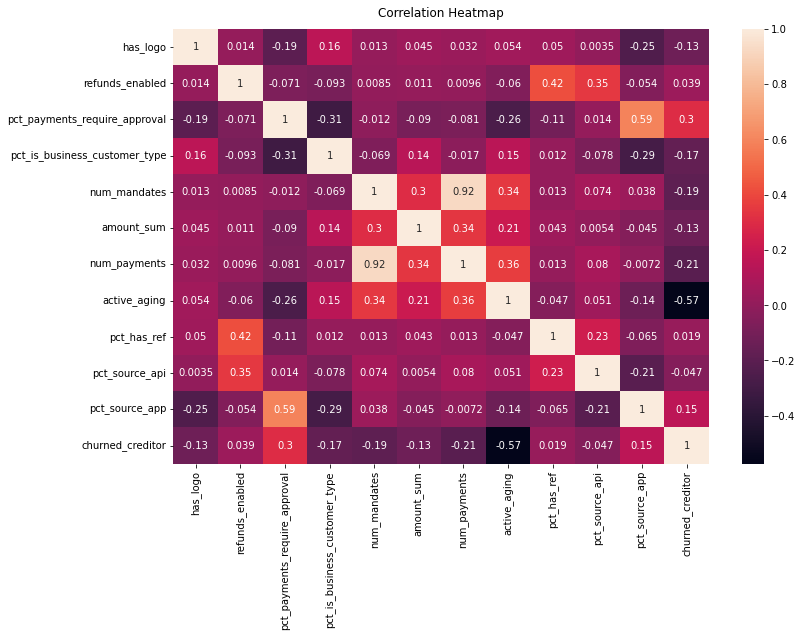

In [86]:
plt.figure(figsize=(12, 8))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df[cols].select_dtypes("number").corr(), annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title("Correlation Heatmap", fontdict={"fontsize": 12}, pad=12);

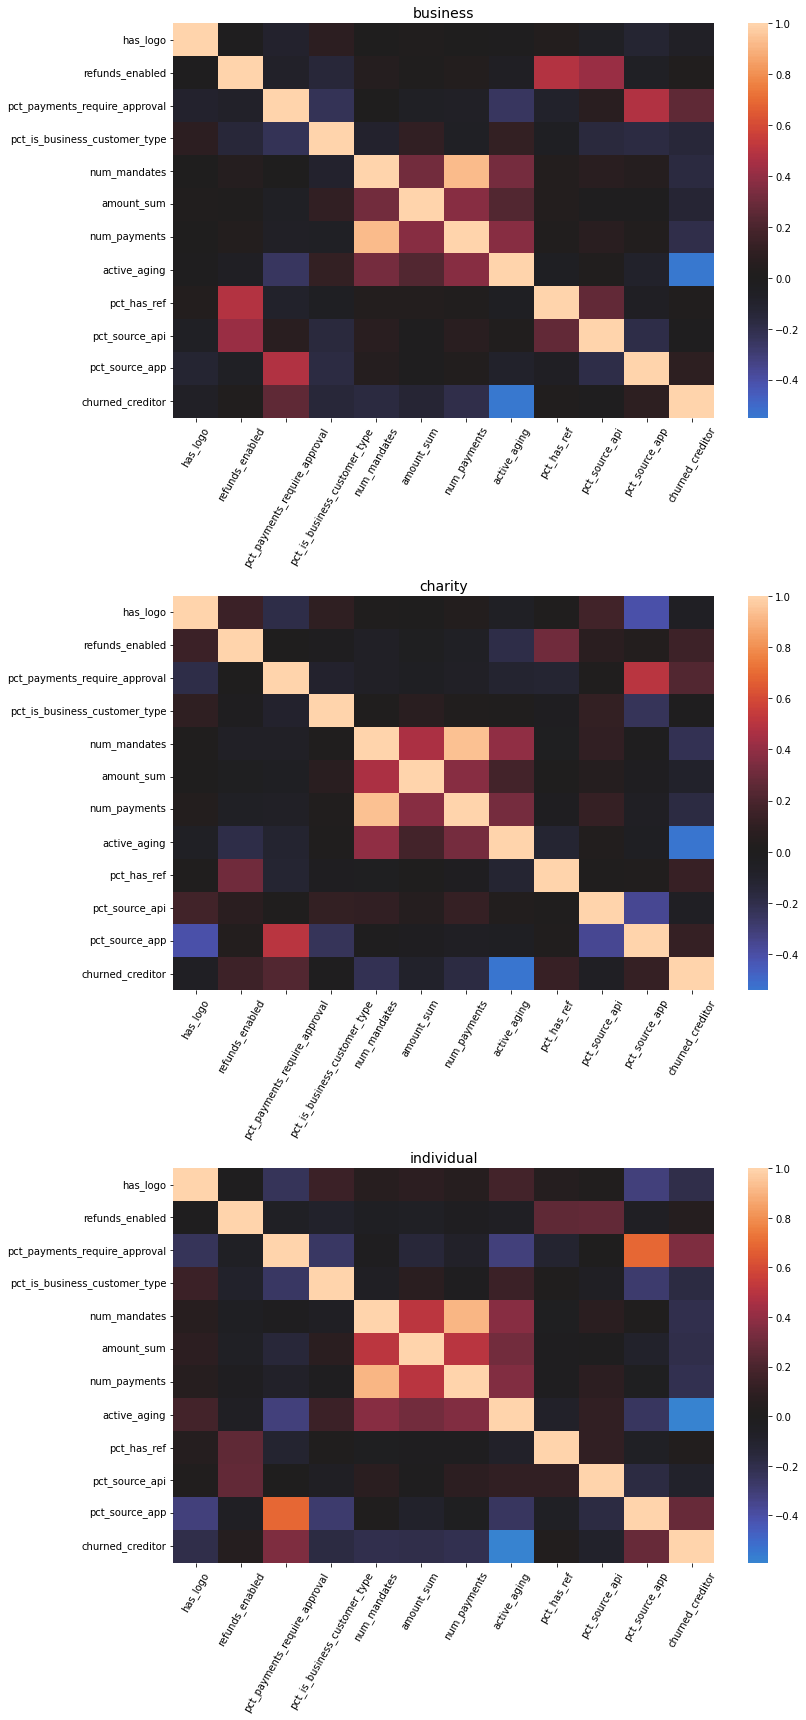

In [41]:
f, axes = plt.subplots(3, 1, figsize=(12, 24))

df_feature = df[cols]
# merchant type
cond = df_feature["merchant_type"] == "business"
corr = df_feature[cond].select_dtypes("number").corr()
ax = sns.heatmap(corr, center=0, ax=axes[0])
ax.set_title("business", fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60)

cond = df_feature["merchant_type"] == "charity"
corr = df_feature[cond].select_dtypes("number").corr()
ax = sns.heatmap(corr, center=0, ax=axes[1])
ax.set_title("charity", fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60)

cond = df_feature["merchant_type"] == "individual"
corr = df_feature[cond].select_dtypes("number").corr()
ax = sns.heatmap(corr, center=0, ax=axes[2])
ax.set_title("individual", fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60)


plt.tight_layout()
plt.show()

# Pipeline:
## 1. Numeric feature
### Feature scaling
ML algrothims don't perform well when the input numerical attribuites have very different scales. 
This is the case for payment stats data and mandate stats data: 
* `amount_sum` ranging from 0 to 679797.83 GBP
* `num_payments` ranging from 1 to 1730
* `num_mandates` ranging from 1 to 509
* `active_aging` ranging from 1 to 274 days
* `pct_payments_require_approval`, `pct_is_business_customer_type`, `pct_has_ref`, `pct_source_app` and `pct_source_api` ranging from 0 to 1

Here I use `StandardScaler` for feature scalling

## 2. Categorical feature

For creditor level data, from above analysis, `merchant_type` contains missing values. 
To replace those missing value for both train and test, I create a `SimpleImputer` instance, specifying that I want replace each attribute's missing value with the most frequent of that attribute. 

There are three categorical attributes which I need to convert them from text to number format. The approach I used `OrdinalEncoder` for boolean feature (`has_logo` and `refunds_enabled`) and `OneHotEncoder` for `marchant_type`
* has_logo: True/False
* refunds_enbaled: True/False
* marchant_type: business/charity/invidual

In [42]:
# Let's take a look at the numerical features
df_feature.describe()

,has_logo,refunds_enabled,pct_payments_require_approval,pct_is_business_customer_type,num_mandates,amount_sum,num_payments,active_aging,pct_has_ref,pct_source_api,pct_source_app,churned_creditor
count,18987,18987,18987.000000,18987.000000,18987.000000,18987.00000,18987.000000,18987.000000,18987.000000,18987.000000,18987.000000,18987.000000
unique,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,10708,17242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,0.272302,0.318504,11.006899,2714.92114,22.698373,92.302207,0.030343,0.066682,0.373817,0.306684
std,NaN,NaN,0.417059,0.425314,25.087274,10528.58841,57.011017,68.122821,0.163940,0.243102,0.477886,0.461129
min,NaN,NaN,0.000000,0.000000,1.000000,0.00000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,0.000000,0.000000,1.000000,102.60000,2.000000,13.000000,0.000000,0.000000,0.000000,0.000000
50%,NaN,NaN,0.000000,0.000000,3.000000,458.01000,6.000000,102.000000,0.000000,0.000000,0.000000,0.000000
75%,NaN,NaN,0.577352,0.800000,10.000000,1986.31000,21.000000,155.000000,0.000000,0.000000,1.000000,1.000000


In [29]:
numeric_features = [
    "amount_sum",
    "num_payments",
    "active_aging",
    "pct_source_api",
    "pct_source_app",
    "pct_has_ref",
    "num_mandates",
    "pct_scheme_bacs",
    "pct_payments_require_approval",
    "pct_is_business_customer_type",
    "pct_source_api",
    "pct_source_app",
]
numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])

categorical_features = [
    "merchant_type",
]
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

binary_features = [
    "has_logo",
    "refunds_enabled",
]
binary_transformer = OrdinalEncoder()


preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
        ("bin", binary_transformer, binary_features),
    ]
)

# Select and Train models

## Training and Evaluating on the training set
### Base model: 
`DummyClassifier`
### Candidate models:
* `Logistic Regression`
* `SVM`
* `DecisionTreeClassifier`
* `RandomForestClassifier`

### Performance evaluation using Cross-Validation
I use cross validation and compare the model performance based on F1 score, precision, recall and ROC AUC. I also use SMOTE to oversample the minority class and evaluate the performance.

The overall performance is:

`RandomForestClassifier > DecisionTreeClassifier >  Logistic Regression > SVM > DummyClassifier`

I will use `RandomForestClassifier` for fine-tuning.

In [30]:
cond = "churned_creditor"
X_train = df.drop([cond], axis=1)
y_train = df[cond]

In [31]:
all_scores = {}

scoring = {
    "precision_macro": "precision_macro",
    "recall_macro": "recall_macro",
    "f1_score": "f1_macro",
    "roc_auc": "roc_auc",
    "accuracy": "accuracy",
}

models = [
    DummyClassifier(),
    LogisticRegression(),
    SVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
]

results = {}
for model in models:

    clf = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", model)])

    all_scores[str(clf)] = scores = cross_validate(
        clf, X_train, y_train, cv=10, scoring=scoring
    )

    print("-" * 40)
    print(str(clf.named_steps.classifier))

    test_scores = {}
    for s in scoring:
        s = "test_" + s
        print(s, np.mean(scores[s]))
        test_scores[s] = np.mean(scores[s])

    results[str(clf.named_steps.classifier).split("(")[0]] = test_scores

----------------------------------------
DummyClassifier()
test_precision_macro 0.34665824339913803
test_recall_macro 0.5
test_f1_score 0.40944293362843365
test_roc_auc 0.5
test_accuracy 0.6933164867982761
----------------------------------------
LogisticRegression()
test_precision_macro 0.779674198938286
test_recall_macro 0.7703535633776166
test_f1_score 0.774466925734868
test_roc_auc 0.873363107944496
test_accuracy 0.8112395964600081
----------------------------------------
SVC()
test_precision_macro 0.7829256967945214
test_recall_macro 0.7602961962883911
test_f1_score 0.7694266267102094
test_roc_auc 0.8619281717088372
test_accuracy 0.8112401790970901
----------------------------------------
DecisionTreeClassifier()
test_precision_macro 0.8536513121500227
test_recall_macro 0.8656329145531814
test_f1_score 0.858928521005668
test_roc_auc 0.8659998669142126
test_accuracy 0.8779659140660245
----------------------------------------
RandomForestClassifier()
test_precision_macro 0.902369164

In [46]:
# Evulation metrics
pd.DataFrame.from_dict(results)

,DummyClassifier,LogisticRegression,SVC,DecisionTreeClassifier,RandomForestClassifier
test_precision_macro,0.346658,0.778965,0.782961,0.853545,0.902598
test_recall_macro,0.500000,0.770070,0.760660,0.864801,0.885233
test_f1_score,0.409443,0.774003,0.769681,0.858562,0.892854
test_roc_auc,0.500000,0.873015,0.861433,0.865164,0.951877
test_accuracy,0.693316,0.810713,0.811345,0.877808,0.910989


In [47]:
# Use SMOTE to over-sampling the minority class

oversample_results = {}
index = "Over-sampling + "
for model in models:

    smote_pipeline = make_pipeline_with_sampler(
        preprocessor, SMOTE(sampling_strategy="minority"), model
    )

    model_name = index + re.split(r"\'(.+?)\'", str(smote_pipeline.steps[-1]))[1]

    all_scores[str(smote_pipeline)] = scores = cross_validate(
        smote_pipeline, X_train, y_train, cv=10, scoring=scoring
    )

    print("-" * 40)
    print(model_name)

    test_scores = {}
    for s in scoring:
        s = "test_" + s
        print(s, np.mean(scores[s]))
        test_scores[s] = np.mean(scores[s])

    oversample_results[model_name] = test_scores

----------------------------------------
Over-sampling + dummyclassifier
test_precision_macro 0.34665824339913803
test_recall_macro 0.5
test_f1_score 0.40944293362843365
test_roc_auc 0.5
test_accuracy 0.6933164867982761
----------------------------------------
Over-sampling + logisticregression
test_precision_macro 0.7570371295613103
test_recall_macro 0.7924326470739289
test_f1_score 0.7642437051477147
test_roc_auc 0.8729660592675568
test_accuracy 0.7829586976895943
----------------------------------------
Over-sampling + svc
test_precision_macro 0.7614385079467806
test_recall_macro 0.8004992376007927
test_f1_score 0.7673580984945352
test_roc_auc 0.8686855367095312
test_accuracy 0.7838542941185284
----------------------------------------
Over-sampling + decisiontreeclassifier
test_precision_macro 0.8446275383701357
test_recall_macro 0.8654559503539794
test_f1_score 0.8533022914460545
test_roc_auc 0.8659474851350184
test_accuracy 0.8712775178106608
--------------------------------------

In [48]:
total_res = results | oversample_results

pd.DataFrame.from_dict(total_res).transpose(copy=True)

,test_precision_macro,test_recall_macro,test_f1_score,test_roc_auc,test_accuracy
DummyClassifier,0.346658,0.500000,0.409443,0.500000,0.693316
LogisticRegression,0.778965,0.770070,0.774003,0.873015,0.810713
SVC,0.782961,0.760660,0.769681,0.861433,0.811345
DecisionTreeClassifier,0.853545,0.864801,0.858562,0.865164,0.877808
RandomForestClassifier,0.902598,0.885233,0.892854,0.951877,0.910989
Over-sampling + dummyclassifier,0.346658,0.500000,0.409443,0.500000,0.693316
Over-sampling + logisticregression,0.757037,0.792433,0.764244,0.872966,0.782959
Over-sampling + svc,0.761439,0.800499,0.767358,0.868686,0.783854
Over-sampling + decisiontreeclassifier,0.844628,0.865456,0.853302,0.865947,0.871278
Over-sampling + randomforestclassifier,0.890412,0.888235,0.889068,0.952228,0.905986


In [69]:
all_scores = {}

scoring = {
    "precision_macro": "precision_macro",
    "recall_macro": "recall_macro",
    "f1_score": "f1_macro",
    "roc_auc": "roc_auc",
    "accuracy": "accuracy",
}

models = [
    DummyClassifier(),
    LogisticRegression(),
    SVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
]

results_pca = {}
for model in models:

    clf = Pipeline(
        steps=[("preprocessor", preprocessor), ("pca", PCA()), ("classifier", model)]
    )

    all_scores[str(clf)] = scores = cross_validate(
        clf, X_train, y_train, cv=10, scoring=scoring
    )

    print("-" * 40)
    print(str(clf.named_steps.classifier))

    test_scores = {}
    for s in scoring:
        s = "test_" + s
        print(s, np.mean(scores[s]))
        test_scores[s] = np.mean(scores[s])

    results_pca[str(clf.named_steps.classifier).split("(")[0]] = test_scores

----------------------------------------
DummyClassifier()
test_precision_macro 0.3469525959367946
test_recall_macro 0.5
test_f1_score 0.4096481690000813
test_roc_auc 0.5
test_accuracy 0.6939051918735892
----------------------------------------
LogisticRegression()
test_precision_macro 0.7776580101390215
test_recall_macro 0.7697351471059619
test_f1_score 0.7732730622031122
test_roc_auc 0.8734968920821149
test_accuracy 0.8100827689992475
----------------------------------------
SVC()
test_precision_macro 0.7784455581129567
test_recall_macro 0.7537365282506185
test_f1_score 0.7634377066897429
test_roc_auc 0.8612621955453384
test_accuracy 0.8075244544770503
----------------------------------------
DecisionTreeClassifier()
test_precision_macro 0.839676710225271
test_recall_macro 0.847202116432752
test_f1_score 0.8431326816981507
test_roc_auc 0.8476285116858115
test_accuracy 0.8651617757712566
----------------------------------------
RandomForestClassifier()
test_precision_macro 0.874305215

In [70]:
# Use SMOTE to over-sampling the minority class

oversample_results_pca = {}
index = "Over-sampling + "
for model in models:

    smote_pipeline = make_pipeline_with_sampler(
        preprocessor, SMOTE(sampling_strategy="minority"), PCA(), model
    )

    model_name = index + re.split(r"\'(.+?)\'", str(smote_pipeline.steps[-1]))[1]

    all_scores[str(smote_pipeline)] = scores = cross_validate(
        smote_pipeline, X_train, y_train, cv=10, scoring=scoring
    )

    print("-" * 40)
    print(model_name)

    test_scores = {}
    for s in scoring:
        s = "test_" + s
        print(s, np.mean(scores[s]))
        test_scores[s] = np.mean(scores[s])

    oversample_results_pca[model_name] = test_scores

----------------------------------------
Over-sampling + dummyclassifier
test_precision_macro 0.3469525959367946
test_recall_macro 0.5
test_f1_score 0.4096481690000813
test_roc_auc 0.5
test_accuracy 0.6939051918735892
----------------------------------------
Over-sampling + logisticregression
test_precision_macro 0.757200557417926
test_recall_macro 0.7931137045955172
test_f1_score 0.764414899047048
test_roc_auc 0.8734663144240324
test_accuracy 0.7831452219714071
----------------------------------------
Over-sampling + svc
test_precision_macro 0.7598768082789266
test_recall_macro 0.800210603926948
test_f1_score 0.7649433517899559
test_roc_auc 0.8669273571658899
test_accuracy 0.7808878856282919
----------------------------------------
Over-sampling + decisiontreeclassifier
test_precision_macro 0.8201397788238353
test_recall_macro 0.8429558731132216
test_f1_score 0.8292207872964316
test_roc_auc 0.843360676565305
test_accuracy 0.8493604213694507
----------------------------------------
Ove

In [71]:
total_res_pca = results_pca | oversample_results_pca

pd.DataFrame.from_dict(total_res_pca).transpose(copy=True)

,test_precision_macro,test_recall_macro,test_f1_score,test_roc_auc,test_accuracy
DummyClassifier,0.346953,0.500000,0.409648,0.500000,0.693905
LogisticRegression,0.777658,0.769735,0.773273,0.873497,0.810083
SVC,0.778446,0.753737,0.763438,0.861262,0.807524
DecisionTreeClassifier,0.839677,0.847202,0.843133,0.847629,0.865162
RandomForestClassifier,0.874305,0.857788,0.865258,0.925976,0.887961
Over-sampling + dummyclassifier,0.346953,0.500000,0.409648,0.500000,0.693905
Over-sampling + logisticregression,0.757201,0.793114,0.764415,0.873466,0.783145
Over-sampling + svc,0.759877,0.800211,0.764943,0.866927,0.780888
Over-sampling + decisiontreeclassifier,0.820140,0.842956,0.829221,0.843361,0.849360
Over-sampling + randomforestclassifier,0.855235,0.862015,0.858390,0.929609,0.878480


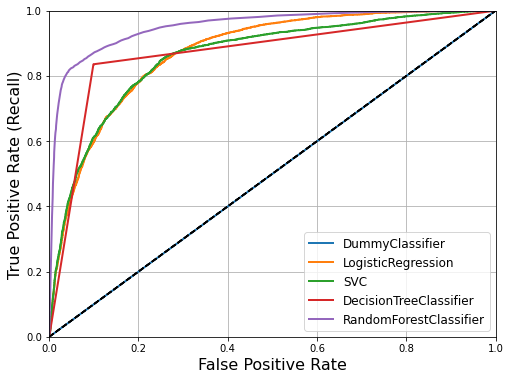

In [50]:
# Comparing ROC curves
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--")
    plt.axis([0, 1, 0, 1])
    plt.xlabel("False Positive Rate", fontsize=16)
    plt.ylabel("True Positive Rate (Recall)", fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True)


plt.figure(figsize=(8, 6))

for model in models:
    clf = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", model)])

    if str(model) in ["LogisticRegression()", "SVC()"]:
        y_scores = cross_val_predict(
            clf, X_train, y_train, cv=10, method="decision_function"
        )
    else:
        y_scores = cross_val_predict(
            clf, X_train, y_train, cv=10, method="predict_proba"
        )[:, 1]

    fpr, tpr, thresholds = roc_curve(y_train, y_scores)

    plot_roc_curve(fpr, tpr, label=str(clf.named_steps.classifier).split("(")[0])

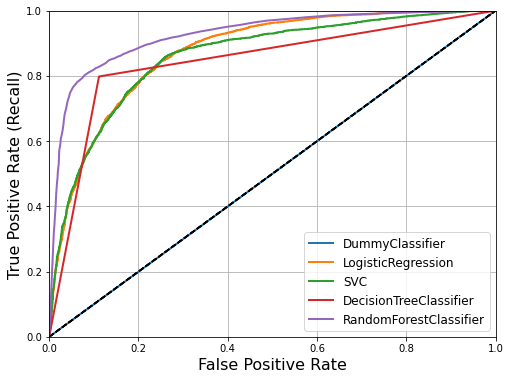

In [68]:
# Comparing ROC curves
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--")
    plt.axis([0, 1, 0, 1])
    plt.xlabel("False Positive Rate", fontsize=16)
    plt.ylabel("True Positive Rate (Recall)", fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True)


plt.figure(figsize=(8, 6))

for model in models:
    clf = Pipeline(
        steps=[("preprocessor", preprocessor), ("pca", PCA()), ("classifier", model)]
    )

    if str(model) in ["LogisticRegression()", "SVC()"]:
        y_scores = cross_val_predict(
            clf, X_train, y_train, cv=10, method="decision_function"
        )
    else:
        y_scores = cross_val_predict(
            clf, X_train, y_train, cv=10, method="predict_proba"
        )[:, 1]

    fpr, tpr, thresholds = roc_curve(y_train, y_scores)

    plot_roc_curve(fpr, tpr, label=str(clf.named_steps.classifier).split("(")[0])

Comparing ROC curves: Random Forest Classifier outperforms than others. The base model Dummy Classifer performs worst. 

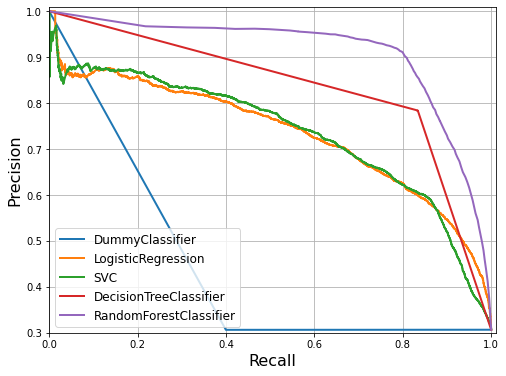

In [32]:
# Precision vs Recall plots
def plot_precision_vs_recall(precisions, recalls, label=None):
    plt.plot(recalls, precisions, linewidth=2, label=label)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.legend(fontsize=12)
    plt.axis([0, 1.01, 0.3, 1.01])
    plt.grid(True)


plt.figure(figsize=(8, 6))

for model in models:
    clf = Pipeline(steps=[("preprocessor", preprocessor),("classifier", model)])

    if str(model) in ["LogisticRegression()", "SVC()"]:
        y_scores = cross_val_predict(
            clf, X_train, y_train, cv=10, method="decision_function"
        )
    else:
        y_scores = cross_val_predict(
            clf, X_train, y_train, cv=10, method="predict_proba"
        )[:, 1]

    precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

    plot_precision_vs_recall(
        precisions, recalls, label=str(clf.named_steps.classifier).split("(")[0]
    )

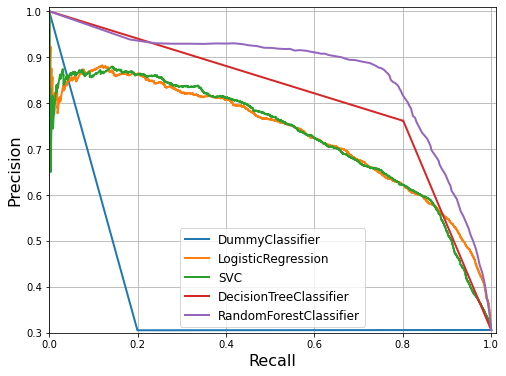

In [67]:
from sklearn.decomposition import PCA

# Precision vs Recall plots
def plot_precision_vs_recall(precisions, recalls, label=None):
    plt.plot(recalls, precisions, linewidth=2, label=label)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.legend(fontsize=12)
    plt.axis([0, 1.01, 0.3, 1.01])
    plt.grid(True)


plt.figure(figsize=(8, 6))

for model in models:
    clf = Pipeline(
        steps=[("preprocessor", preprocessor), ("pca", PCA()), ("classifier", model)]
    )

    if str(model) in ["LogisticRegression()", "SVC()"]:
        y_scores = cross_val_predict(
            clf, X_train, y_train, cv=10, method="decision_function"
        )
    else:
        y_scores = cross_val_predict(
            clf, X_train, y_train, cv=10, method="predict_proba"
        )[:, 1]

    precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

    plot_precision_vs_recall(
        precisions, recalls, label=str(clf.named_steps.classifier).split("(")[0]
    )

In [53]:
rf_params_grid = {
#     "pca__n_components": [6, 8, 10],
    "clf__n_estimators": [
        60,
        80,
        100,
        120,
    ],  # [10, 20, 30, 40, 50, 60, 70, 80], #list(range(2, 50, 2)),
    "clf__max_features": ["auto", "sqrt"],
    "clf__max_depth": [3, 5, 7, 9, 11],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [2, 4, 6],
}

full_pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
#         ("pca", PCA()),
        ("clf", RandomForestClassifier()),
    ]
)


grid_rf = GridSearchCV(
    full_pipe, param_grid=rf_params_grid, cv=5, scoring="f1", n_jobs=-1
)
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['amount_sum',
                                                                          'num_payments',
                                                                          'active_aging',
                                                                          'pct_source_api',
                                                                          'pct_source_app',
                                                                          'pct_has_ref',
                                                                          'num_mandates',
                                                                          'pct_scheme_bacs',
                                                                          'pct_payments_require_approval',
                                                                          'pct_is_business_customer_type',
                                                                          'pct_source_api'...
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['merchant_type']),
                                                                        ('bin',
                                                                         OrdinalEncoder(),
                                                                         ['has_logo',
                                                                          'refunds_enabled'])])),
                                       ('clf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'clf__max_depth': [3, 5, 7, 9, 11],
                         'clf__max_features': ['auto', 'sqrt'],
                         'clf__min_samples_leaf': [2, 4, 6],
                         'clf__min_samples_split': [2, 5, 10],
                         'clf__n_estimators': [60, 80, 100, 120]},
             scoring='f1')

In [54]:
import pprint

final_model = grid_rf.best_estimator_
pp = pprint.PrettyPrinter(indent=4)
# pp.pprint(final_model.named_steps["pca"].get_params())
pp.pprint(final_model.named_steps["clf"].get_params())

{   'bootstrap': True,
    'ccp_alpha': 0.0,
    'class_weight': None,
    'criterion': 'gini',
    'max_depth': 11,
    'max_features': 'sqrt',
    'max_leaf_nodes': None,
    'max_samples': None,
    'min_impurity_decrease': 0.0,
    'min_samples_leaf': 2,
    'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0,
    'n_estimators': 60,
    'n_jobs': None,
    'oob_score': False,
    'random_state': None,
    'verbose': 0,
    'warm_start': False}


In [55]:
grid_rf.best_score_

0.7312577822776765

In [63]:
import pprint

final_model = grid_rf.best_estimator_
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(final_model.named_steps["clf"].get_params())

{   'bootstrap': True,
    'ccp_alpha': 0.0,
    'class_weight': None,
    'criterion': 'gini',
    'max_depth': 11,
    'max_features': 'auto',
    'max_leaf_nodes': None,
    'max_samples': None,
    'min_impurity_decrease': 0.0,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0,
    'n_estimators': 80,
    'n_jobs': None,
    'oob_score': False,
    'random_state': None,
    'verbose': 0,
    'warm_start': False}


In [56]:
from sklearn.metrics import classification_report

y_pred = cross_val_predict(final_model, X_train, y_train, cv=5)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.91      0.89      9222
           1       0.77      0.70      0.73      4068

    accuracy                           0.84     13290
   macro avg       0.82      0.80      0.81     13290
weighted avg       0.84      0.84      0.84     13290



In [33]:
import joblib

model = joblib.load("churn_model.pkl")

In [34]:
y_scores = cross_val_predict(model, X_train, y_train, cv=5, method="predict_proba")

In [35]:
y_scores

array([[0.9169274 , 0.0830726 ],
       [0.93927328, 0.06072672],
       [0.27172161, 0.72827839],
       ...,
       [0.99494045, 0.00505955],
       [0.98590785, 0.01409215],
       [0.20372429, 0.79627571]])

In [37]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores[:,1])

In [39]:
thresholds

array([0.00388282, 0.00388626, 0.00388641, ..., 0.98668721, 0.98990733,
       0.99002099])

In [43]:
precisions

array([0.31887629, 0.31883899, 0.31885645, ..., 1.        , 1.        ,
       1.        ])

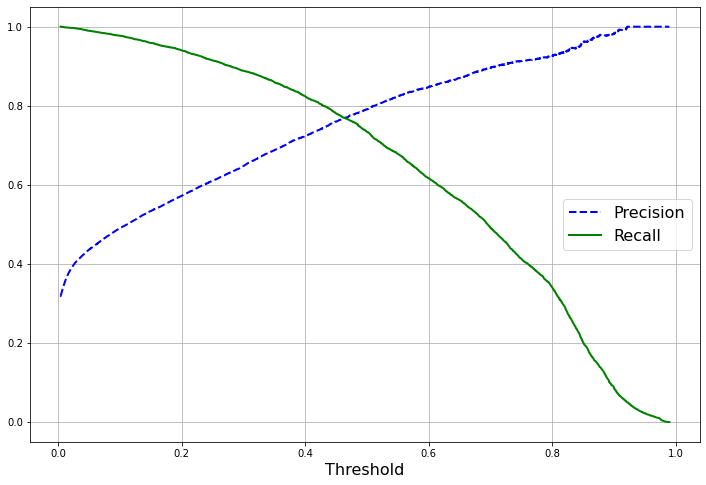

In [45]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
#     plt.axis([-50000, 50000, 0, 1])             # Not shown



# recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
# threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(12, 8))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
# plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
# plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
# plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
# plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
# plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
# save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
# plt.show()

In [46]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3)

<Figure size 864x576 with 0 Axes>

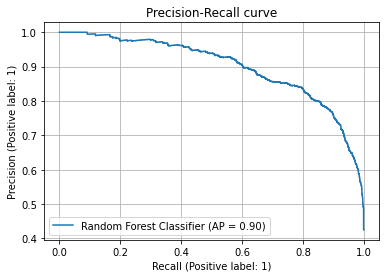

In [48]:
from sklearn.metrics import PrecisionRecallDisplay

plt.figure(figsize=(12, 8))


display = PrecisionRecallDisplay.from_estimator(
    model, X_test, y_test, name="Random Forest Classifier"
)
_ = display.ax_.set_title("Precision-Recall curve")
plt.grid()

<Figure size 864x576 with 0 Axes>

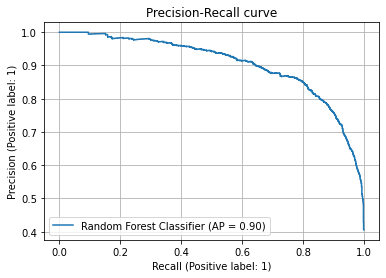

In [65]:
from sklearn.metrics import PrecisionRecallDisplay

plt.figure(figsize=(12, 8))


display = PrecisionRecallDisplay.from_estimator(
    model, X_test, y_test, name="Random Forest Classifier"
)
_ = display.ax_.set_title("Precision-Recall curve")
plt.grid()

In [49]:
y_score = model.predict(X_test)

In [50]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_score)

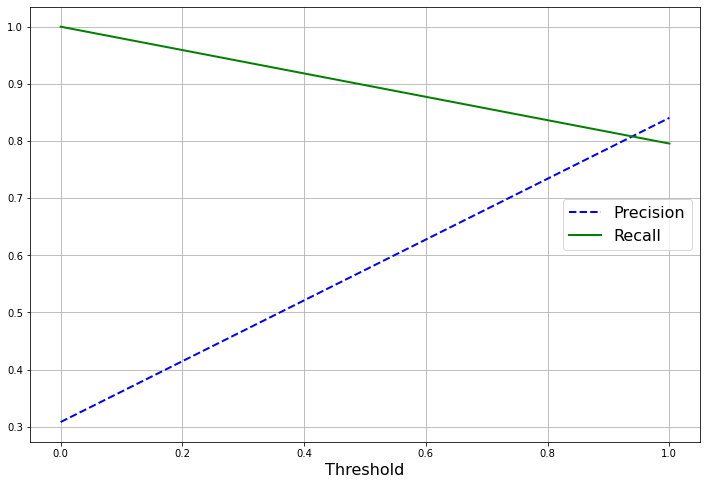

In [51]:
plt.figure(figsize=(12, 8))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

# Plot a learning curve

A learning curve shows the validation and training score of the model for varying numbers of training samples. 

According to the result, we can see for small amounts of data, the training score of my model is much greater than the cross validations score. Adding more training samples will most likely increase generalization but still have a gap between training score and validation score. It shows the model is slightly overfitting. 

Unfortunately due to time contsratints, I won't do further hypertuning analysis but will suggest:
* More training data required (e.g. include the data before 2016)
* Continue to twking hyper parameters
* Exploring alternative models

<module 'matplotlib.pyplot' from '/Users/kejiongli/opt/anaconda3/envs/ml/lib/python3.9/site-packages/matplotlib/pyplot.py'>

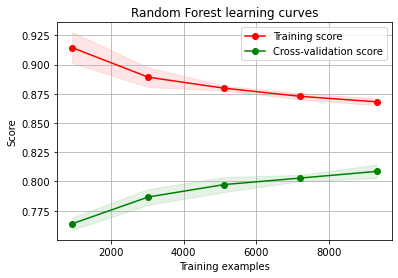

In [57]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    ylim=None,
    cv=None,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5),
):

    plt.figure()
    plt.title(title)

    if ylim is not None:
        plt.ylim(*ylim)

    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        scoring="f1_macro",
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    plt.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )

    plt.legend(loc="best")

    return plt


cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)

plot_learning_curve(
    final_model,
    "Random Forest learning curves",
    X_train,
    y_train,
    cv=cv,
    n_jobs=-1,
)

# Visualize feature scores of the features

In this section, I will visualize the feature scores.

In [66]:
cat_encoder = final_model.named_steps["preprocessor"].named_transformers_["cat"]
cat_list = list(cat_encoder.named_steps["onehot"].categories_)
cat_attributes = binary_features + list(cat_list[0])
attributes = numeric_features + cat_attributes

Text(0.5, 1.0, 'Random Forest Classifier Feature Importance')

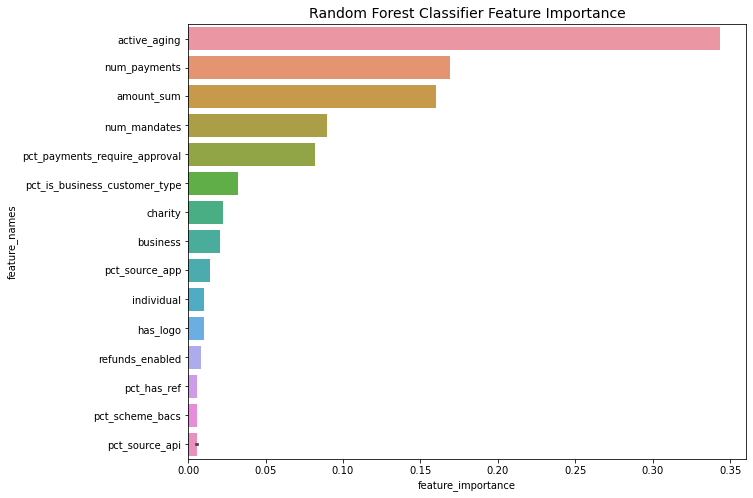

In [67]:
feature_importances = final_model.named_steps["clf"].feature_importances_
rf_feature_importances = sorted(zip(feature_importances, attributes), reverse=True)
forest_importances = pd.DataFrame(
    rf_feature_importances, columns=["feature_importance", "feature_names"]
)
plt.figure(figsize=(10, 8))
sns.barplot(
    x=forest_importances["feature_importance"], y=forest_importances["feature_names"]
)
plt.title("Random Forest Classifier Feature Importance", fontsize=14)

# Save model

In [68]:
import joblib

joblib.dump(final_model, "churn_model.pkl")

['churn_model.pkl']

# Predict Q1 2017

#### Step 1: Find churned creditor since Q4 2016

#### Step 2: Extract the test data
The `creditor_id` that are active since Q4 2016 will be the ones we want to predict for Q1 2017.
Since I choose 6-month windows, then I need to extract those creditor id's data records for the latest 6 months, from 2016-7-1 to 2016-12-31, for prediction. 

#### Step 3: Prediction is followed by the pipeline described in previous section and get the predicted probabilities
1. Create features for each `creditor_id`
2. Process the model pipeline

#### Step 4: Save results into a csv file as requested

In [69]:
# Step 1: Find churned creditors since Q4 2016
cond = merged["payment_created_at"] >= datetime.datetime(
    2016, 10, 1, tzinfo=datetime.timezone.utc
)
churned_creditor_ids_preQ4 = set(merged["creditor_id"]) - set(
    merged[cond]["creditor_id"]
)

In [70]:
# Step 2: Test data will be active creditor ids(since Q4)'s 6 months data that from 2016-7-1 to 2016-12-31
start = datetime.datetime(2016, 7, 1, tzinfo=datetime.timezone.utc)
df_6months = merged[(start <= merged["payment_created_at"])]
df_test = df_6months[~df_6months["creditor_id"].isin(churned_creditor_ids_preQ4)]

In [71]:
# Step 3: Prediction is follwed by the pipeline described in previous section
X_test = process_creditor_data(df_test)
y_proba = final_model.predict_proba(X_test)[:, 1]

result = dict(zip(X_test["creditor_id"], y_proba))
res = pd.DataFrame(result.items(), columns=["id", "probability"])

In [72]:
# Step 4: Generate the probability and save into csv file as requested.
res.to_csv("prediction.csv")

NameError: name 'merged' is not defined